## Efficient Deep Learning Approach for Multiclass Sound Classification

> This a semester final mini project of deep learning 2CSI

**Authors**:
[texte du lien](https://)

## Installing Dependencies

In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torchaudio # for audio processing
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB, TimeMasking, FrequencyMasking
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from datasets import load_dataset
import io

## Configuration setup

These are the key **hyperparameters** for training:

- `sample_rate`: The number of samples per second in an audio clip.
- `n_mels`: Number of mel-frequency bins in spectrograms.
- `batch_size`: Number of samples per batch for training.
- `epochs`: Total training cycles.
- `learning_rate`: Step size for optimizer updates.
- `train_split`: Proportion of data used for training.
- `patience`: How long to wait before early stopping.

In [4]:
CONFIG = {
    "sample_rate": 16000,
    "n_mels": 128,
    "n_fft": 1024,
    "hop_length": 512,
    "batch_size": 32,
    "epochs": 60,
    "learning_rate": 1e-4,
    "audio_duration": 2,
    "num_classes": 10,  # TUT Urban Acoustic Scenes also has 10 classes
    "train_split": 0.8,
    "patience": 10,
    "lr_decay_factor": 0.5,
    "lr_decay_patience": 2,
    "weight_decay": 5e-4,
    "mixup_alpha": 0.4  # Mixup hyperparameter (higher means stronger mixup)
}

In [5]:
# TUT Urban Acoustic Scenes 2018 class names
CLASS_NAMES = [
    "airport", "bus", "metro", "metro_station", "park",
    "public_square", "shopping_mall", "street_pedestrian", "street_traffic", "tram"
]

## Loading the HuggingFace dataset

In [6]:
# Load the dataset from HuggingFace
dataset = load_dataset("wetdog/TUT-urban-acoustic-scenes-2018-development-16bit")
print(f"Dataset loaded: {dataset}")

README.md:   0%|          | 0.00/8.95k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/24 [00:00<?, ?it/s]

(…)-00000-of-00024-86bd42cf69e418c9.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00001-of-00024-00459a414f6ab38e.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

(…)-00002-of-00024-2709c59394115a9a.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

(…)-00003-of-00024-c93172123f93ee45.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00004-of-00024-ea77e40f2d6f1a71.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00005-of-00024-b59a8fb77fdf9c89.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00006-of-00024-d6749ded54d7977e.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00007-of-00024-80752ded111ba8b6.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

(…)-00008-of-00024-e41fa66745635e0e.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00009-of-00024-7d90d41254bd41d2.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

(…)-00010-of-00024-cbb3f877d4bcaa06.parquet:   0%|          | 0.00/463M [00:00<?, ?B/s]

(…)-00011-of-00024-dfb689e4f75a88de.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00012-of-00024-62cc21332729eaf3.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00013-of-00024-9091e1e70a4d3271.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00014-of-00024-d2823b10108fc4ad.parquet:   0%|          | 0.00/477M [00:00<?, ?B/s]

(…)-00015-of-00024-b71dd2c6a66f6c3c.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

(…)-00016-of-00024-62f8b62737772e58.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

(…)-00017-of-00024-a3ec2943c017e714.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

(…)-00018-of-00024-f23162d50808b9eb.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00019-of-00024-22a5f120a4aa6ea0.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00020-of-00024-297e34bdda992434.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00021-of-00024-be71fe53ffbfb550.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

(…)-00022-of-00024-feaeff9ef7a73d15.parquet:   0%|          | 0.00/488M [00:00<?, ?B/s]

(…)-00023-of-00024-50e0d138f35e36f0.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

(…)-00000-of-00010-02f08c1bf5f9513f.parquet:   0%|          | 0.00/480M [00:00<?, ?B/s]

(…)-00001-of-00010-b0971793f567c041.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00002-of-00010-333db35af6491bfa.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

(…)-00003-of-00010-4e780d1e0d64daeb.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00004-of-00010-7ec2951286d28d0a.parquet:   0%|          | 0.00/453M [00:00<?, ?B/s]

(…)-00005-of-00010-ecf19a7e04056bba.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00006-of-00010-10debfb02cd60453.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

(…)-00007-of-00010-636831f43e145346.parquet:   0%|          | 0.00/479M [00:00<?, ?B/s]

(…)-00008-of-00010-d507792dc78c0b8f.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

(…)-00009-of-00010-f7f98756212511db.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/6122 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2518 [00:00<?, ? examples/s]

Dataset loaded: DatasetDict({
    train: Dataset({
        features: ['file_name', 'label', 'audio', 'city', 'location_id'],
        num_rows: 6122
    })
    test: Dataset({
        features: ['file_name', 'label', 'audio', 'city', 'location_id'],
        num_rows: 2518
    })
})


## Defining the AudioDataset class for HuggingFace dataset

In [116]:
class AudioDataset(Dataset):
    def __init__(self, hf_dataset, train=True):
        self.dataset = hf_dataset
        self.train = train

        self.mel_spec_transform = MelSpectrogram(
            sample_rate=CONFIG["sample_rate"],
            n_fft=CONFIG["n_fft"],
            hop_length=CONFIG["hop_length"],
            n_mels=CONFIG["n_mels"]
        )
        self.amp_to_db = AmplitudeToDB(top_db=80)

        # Spectrogram augmentations (SpecAugment)
        self.time_mask = TimeMasking(time_mask_param=20)
        self.freq_mask = FrequencyMasking(freq_mask_param=10)

        # Map class names to indices
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(CLASS_NAMES)}

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        audio = item['audio']

        # Convert to tensor
        waveform = torch.tensor(audio['array']).unsqueeze(0)
        sr = audio['sampling_rate']

        # Get label
        scene_label = item['label']
        label = self.class_to_idx[scene_label]

        if sr != CONFIG["sample_rate"]:
            # build a float32 resampler so kernel is float32
            resampler = torchaudio.transforms.Resample(
                orig_freq=sr,
                new_freq=CONFIG["sample_rate"],
                dtype=torch.float32
            )
            # ensure your waveform is float32
            waveform = resampler(waveform.float())

        # Ensure consistent length
        target_length = int(CONFIG["audio_duration"] * CONFIG["sample_rate"])
        if waveform.size(1) > target_length:
            start = np.random.randint(0, waveform.size(1) - target_length) if self.train else 0
            waveform = waveform[:, start:start + target_length]
        else:
            waveform = F.pad(waveform, (0, target_length - waveform.size(1)))

        # ----- Waveform Augmentations -----
        if self.train:
            waveform = torch.roll(waveform, shifts=np.random.randint(-1600, 1600), dims=1)
            waveform = waveform * np.random.uniform(0.8, 1.2)
        # -----------------------------------

        mel_spec = self.mel_spec_transform(waveform)
        mel_spec = self.amp_to_db(mel_spec)
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-8)  # Normalize

        if self.train:
            mel_spec = self.time_mask(mel_spec)
            mel_spec = self.freq_mask(mel_spec)

        return mel_spec, label


**Mixup** is a data augmentation technique where two training samples are mixed together using a random weight $λ$.

- It helps improve model generalization.
- It prevents the model from becoming overconfident.
- Instead of training on a single label, the model learns a weighted combination of labels.

In [117]:
# Mixup augmentation
def mixup_data(x, y, alpha=CONFIG["mixup_alpha"]):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Function to display a spectrogram

In [118]:
def plot_spectrogram(audio_data, sample_rate):
    waveform = torch.tensor(audio_data).unsqueeze(0)
    mel_spec_transform = MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=CONFIG["n_fft"],
        hop_length=CONFIG["hop_length"],
        n_mels=CONFIG["n_mels"]
    )
    mel_spec = mel_spec_transform(waveform)
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec.log2()[0].numpy(), cmap="inferno", aspect="auto")
    plt.title("Mel Spectrogram")
    plt.show()

## Defining the model architecture

In [119]:
class EfficientResNetAudio(nn.Module):
    def __init__(self, num_classes=10, input_channels=1):
        super(EfficientResNetAudio, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

## Defining how the training epoch should be like

In [120]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, all_preds, all_labels = 0, [], []

    for data, target in tqdm(train_loader, desc="Training"):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Apply Mixup augmentation
        mixed_data, targets_a, targets_b, lam = mixup_data(data, target, CONFIG["mixup_alpha"])
        output = model(mixed_data)

        loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(output.argmax(dim=1).cpu().numpy())
        all_labels.extend(target.cpu().numpy())

    return total_loss / len(train_loader), f1_score(all_labels, all_preds, average='macro')

## Model training

In [121]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [122]:
# Create datasets from HuggingFace dataset
train_hf_dataset = dataset["train"]
train_dataset = AudioDataset(train_hf_dataset, train=True)

In [123]:
# Split into train and validation
train_size = int(CONFIG["train_split"] * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

In [124]:
train_loader = DataLoader(train_subset, batch_size=CONFIG["batch_size"], shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=CONFIG["batch_size"], shuffle=False, num_workers=4, pin_memory=True)

In [125]:
model = EfficientResNetAudio(num_classes=CONFIG["num_classes"]).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"])

In [126]:
# Training loop with validation
best_val_f1 = 0
patience_counter = 0
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=CONFIG["lr_decay_factor"],
    patience=CONFIG["lr_decay_patience"],
    verbose=True
)

In [ ]:
for epoch in range(CONFIG["epochs"]):
    # Training
    train_loss, train_f1 = train_epoch(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{CONFIG['epochs']} - Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}")

    # Validation
    model.eval()
    val_loss, val_preds, val_labels = 0, [], []
    with torch.no_grad():
        for data, target in tqdm(val_loader, desc="Validating"):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
            val_preds.extend(output.argmax(dim=1).cpu().numpy())
            val_labels.extend(target.cpu().numpy())

    val_loss /= len(val_loader)
    val_f1 = f1_score(val_labels, val_preds, average='macro')
    print(f"Validation Loss: {val_loss:.4f}, Validation F1: {val_f1:.4f}")

    # Learning rate scheduler
    scheduler.step(val_f1)

    # Early stopping
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"Saved best model with F1: {best_val_f1:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= CONFIG["patience"]:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

Training: 100%|██████████| 154/154 [01:18<00:00,  1.95it/s]


Epoch 1/60 - Train Loss: 2.0980, Train F1: 0.1990


Validating: 100%|██████████| 39/39 [00:21<00:00,  1.85it/s]


Validation Loss: 1.7894, Validation F1: 0.3835
Saved best model with F1: 0.3835


Training: 100%|██████████| 154/154 [00:58<00:00,  2.61it/s]


Epoch 2/60 - Train Loss: 1.8824, Train F1: 0.2657


Validating: 100%|██████████| 39/39 [00:21<00:00,  1.86it/s]


Validation Loss: 1.6265, Validation F1: 0.4537
Saved best model with F1: 0.4537


Training: 100%|██████████| 154/154 [01:13<00:00,  2.10it/s]


Epoch 3/60 - Train Loss: 1.8451, Train F1: 0.2863


Validating: 100%|██████████| 39/39 [00:16<00:00,  2.31it/s]


Validation Loss: 1.4993, Validation F1: 0.5326
Saved best model with F1: 0.5326


Training: 100%|██████████| 154/154 [01:01<00:00,  2.52it/s]


Epoch 4/60 - Train Loss: 1.7255, Train F1: 0.3091


Validating: 100%|██████████| 39/39 [00:13<00:00,  2.83it/s]


Validation Loss: 1.6153, Validation F1: 0.4561


Training: 100%|██████████| 154/154 [00:58<00:00,  2.63it/s]


Epoch 5/60 - Train Loss: 1.7220, Train F1: 0.2902


Validating: 100%|██████████| 39/39 [00:13<00:00,  2.79it/s]


Validation Loss: 1.4300, Validation F1: 0.5679
Saved best model with F1: 0.5679


Training: 100%|██████████| 154/154 [00:53<00:00,  2.91it/s]


Epoch 6/60 - Train Loss: 1.6705, Train F1: 0.3508


Validating: 100%|██████████| 39/39 [00:13<00:00,  2.82it/s]


Validation Loss: 1.4398, Validation F1: 0.5493


Training: 100%|██████████| 154/154 [00:53<00:00,  2.88it/s]


Epoch 7/60 - Train Loss: 1.6204, Train F1: 0.3322


Validating: 100%|██████████| 39/39 [00:14<00:00,  2.68it/s]


Validation Loss: 1.3528, Validation F1: 0.6029
Saved best model with F1: 0.6029


Training: 100%|██████████| 154/154 [00:55<00:00,  2.77it/s]


Epoch 8/60 - Train Loss: 1.6113, Train F1: 0.3692


Validating: 100%|██████████| 39/39 [00:13<00:00,  2.83it/s]


Validation Loss: 1.2847, Validation F1: 0.6347
Saved best model with F1: 0.6347


Training: 100%|██████████| 154/154 [01:10<00:00,  2.19it/s]


Epoch 9/60 - Train Loss: 1.5905, Train F1: 0.3551


Validating: 100%|██████████| 39/39 [00:18<00:00,  2.08it/s]


Validation Loss: 1.3195, Validation F1: 0.6138


Training: 100%|██████████| 154/154 [01:13<00:00,  2.09it/s]


Epoch 10/60 - Train Loss: 1.5587, Train F1: 0.3599


Validating: 100%|██████████| 39/39 [00:14<00:00,  2.77it/s]


Validation Loss: 1.2416, Validation F1: 0.6705
Saved best model with F1: 0.6705


Training: 100%|██████████| 154/154 [00:54<00:00,  2.85it/s]


Epoch 11/60 - Train Loss: 1.5991, Train F1: 0.3621


Validating: 100%|██████████| 39/39 [00:15<00:00,  2.51it/s]


Validation Loss: 1.4340, Validation F1: 0.5550


Training: 100%|██████████| 154/154 [00:54<00:00,  2.85it/s]


Epoch 12/60 - Train Loss: 1.5268, Train F1: 0.3766


Validating: 100%|██████████| 39/39 [00:13<00:00,  2.83it/s]


Validation Loss: 1.1939, Validation F1: 0.6823
Saved best model with F1: 0.6823


Training: 100%|██████████| 154/154 [00:54<00:00,  2.81it/s]


Epoch 13/60 - Train Loss: 1.4748, Train F1: 0.4000


Validating: 100%|██████████| 39/39 [00:16<00:00,  2.31it/s]


Validation Loss: 1.1957, Validation F1: 0.6482


Training:  57%|█████▋    | 88/154 [00:31<00:18,  3.48it/s]

In [128]:
# Load best model for evaluation
model.load_state_dict(torch.load('best_model.pth'))

/tmp/ipykernel_31/988715780.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

## Model Evaluation

In [129]:
def evaluate_model(model, test_loader, device, class_names=CLASS_NAMES):
    """
    Comprehensive evaluation of the model with detailed metrics and visualizations

    Args:
        model: The trained model to evaluate
        test_loader: DataLoader for test data
        device: Device to use for computation
        class_names: List of class names
    """
    model.eval()  # Set model to evaluation mode
    all_preds, all_labels = [], []

    # Collect predictions
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc="Evaluating"):
            data, target = data.to(device), target.to(device)
            output = model(data)

            preds = output.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(target.cpu().numpy())

    # Calculate metrics
    f1 = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')

    # Print overall metrics
    print(f"Test F1 Score (Macro): {f1:.4f}")
    print(f"Precision (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")

    # Generate and plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Generate per-class metrics
    report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
    report_df = pd.DataFrame(report).transpose()

    # Save metrics to CSV
    report_df.to_csv('classification_report.csv')
    print("Classification report saved to 'classification_report.csv'")

    # Show per-class F1 scores
    plt.figure(figsize=(12, 6))
    class_f1_scores = [report[c]['f1-score'] for c in class_names]
    bars = plt.bar(class_names, class_f1_scores)
    plt.xlabel('Classes')
    plt.ylabel('F1 Score')
    plt.title('F1 Score per Class')
    plt.xticks(rotation=45, ha='right')

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.2f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig('f1_scores_per_class.png', bbox_inches='tight', dpi=300)
    plt.show()

    # Save all results to a single file
    results = {
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'per_class_metrics': report
    }

    # Save as pickle for later use
    with open('evaluation_results.pkl', 'wb') as f:
        pickle.dump(results, f)

    return results

Evaluating: 100%|██████████| 39/39 [00:13<00:00,  2.80it/s]


Test F1 Score (Macro): 0.8631
Precision (Macro): 0.8649
Recall (Macro): 0.8646


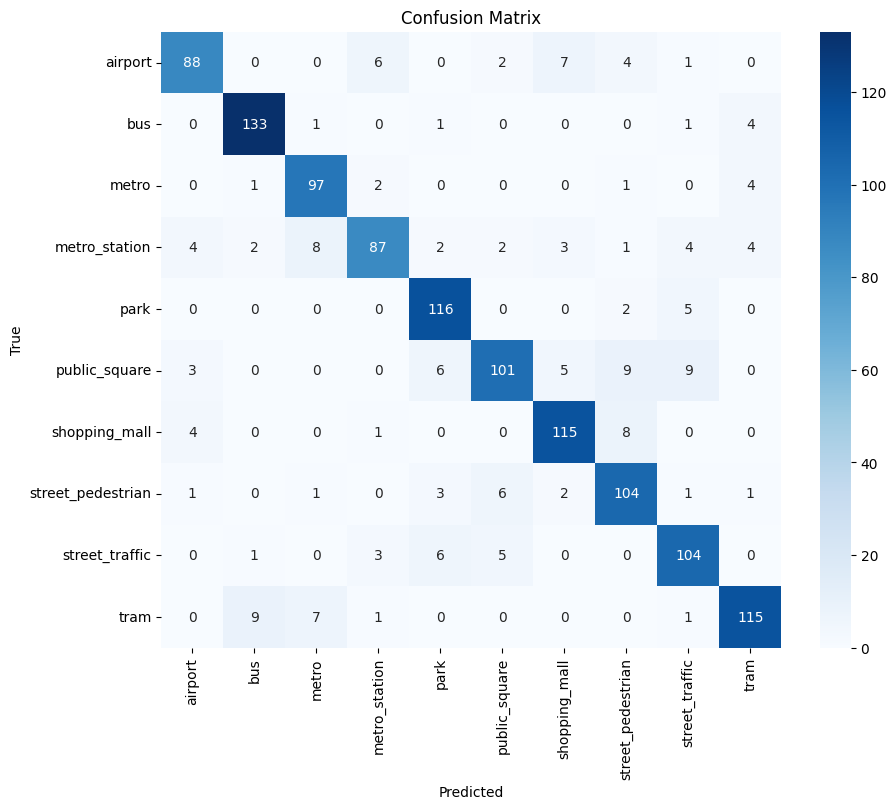

Classification report saved to 'classification_report.csv'


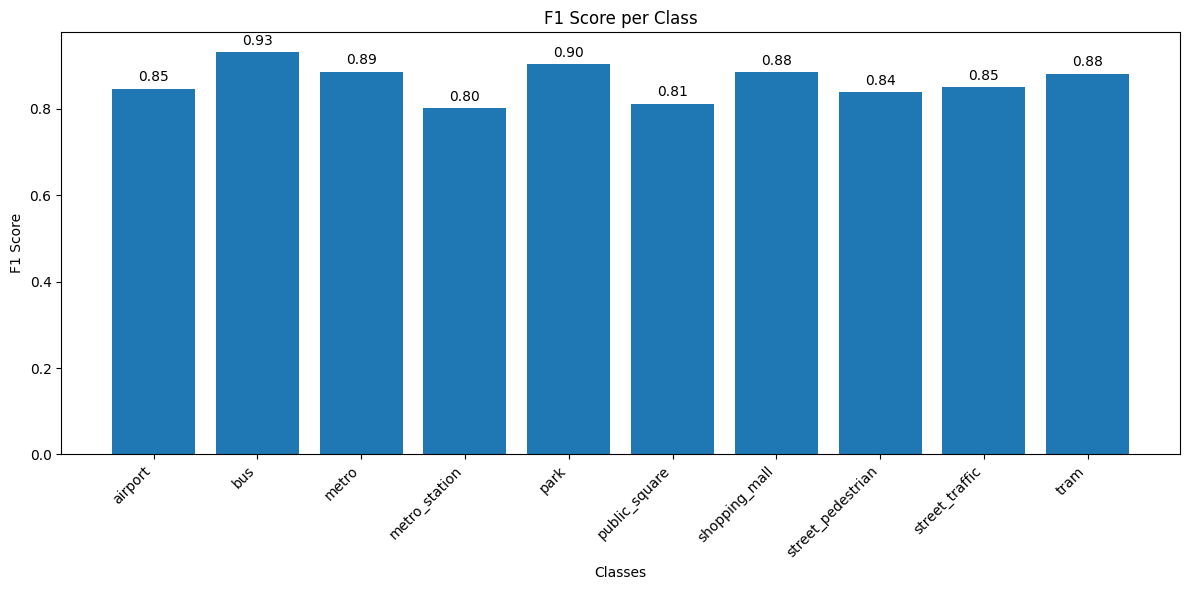

In [130]:
# Evaluate the model on validation set
evaluation_results = evaluate_model(model, val_loader, device)

## Visualize some examples from the dataset

In [131]:
def visualize_dataset_examples():
    # Get a few examples
    examples = dataset["train"].select(range(5))

    fig, axes = plt.subplots(5, 1, figsize=(10, 15))

    for i, example in enumerate(examples):
        audio = example['audio']
        waveform = audio['array']
        sr = audio['sampling_rate']
        scene = example['scene_label']

        # Plot waveform
        axes[i].plot(waveform)
        axes[i].set_title(f"Class: {scene}")
        axes[i].set_ylabel("Amplitude")

    plt.tight_layout()
    plt.show()

    # Also show spectrograms
    for example in examples:
        audio = example['audio']
        waveform = audio['array']
        sr = audio['sampling_rate']
        scene = example['scene_label']

        print(f"Spectrogram for class: {scene}")
        plot_spectrogram(waveform, sr)

KeyError: 'scene_label'

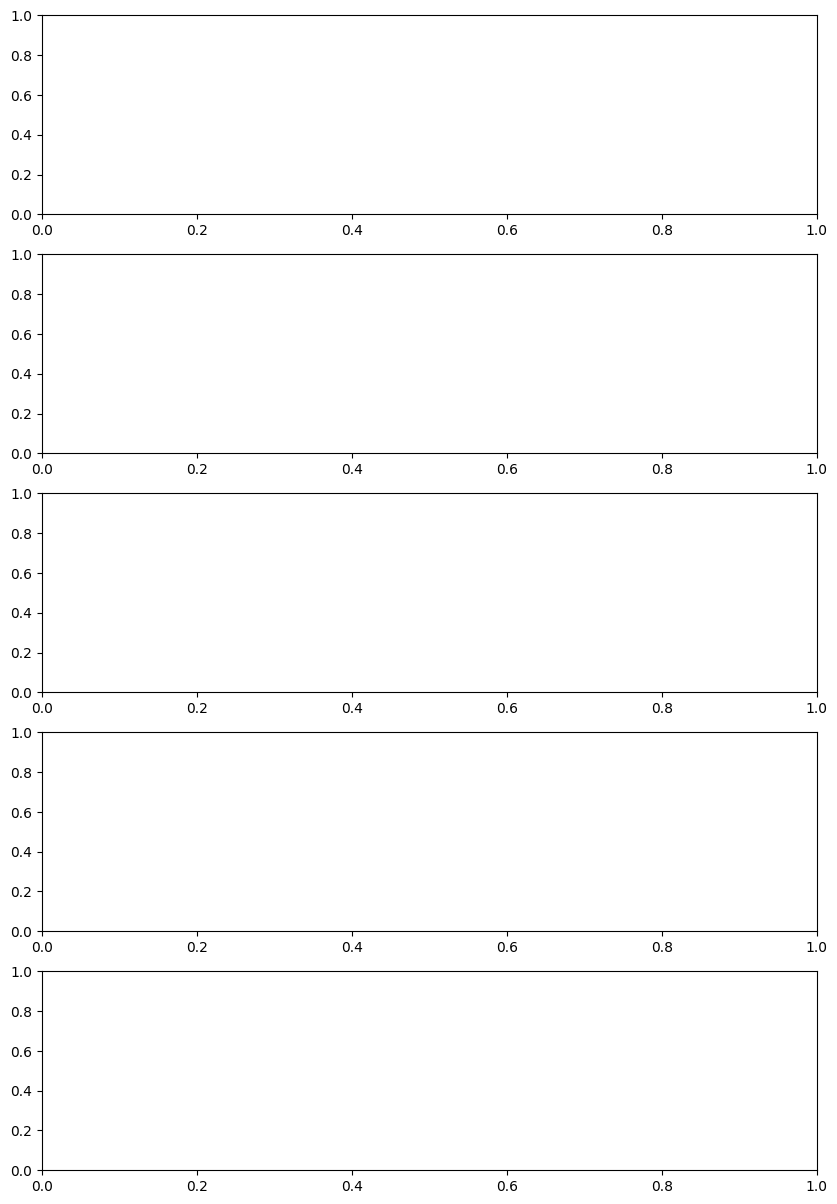

In [132]:
visualize_dataset_examples()